# E-commerce Business Transaction Data Analysis
Data source: https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business

### Step 1: Setting up the environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Step 2: Loading and Inspecting the Data

In [2]:
file = "/Users/ramilojr.subiate/Documents/FILES/etl-to-dashboard/kaggle_data/sales_transaction.csv"
df = pd.read_csv(file)

In [3]:
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [4]:
df.shape

(536350, 8)

In [5]:
df.columns

Index(['TransactionNo', 'Date', 'ProductNo', 'ProductName', 'Price',
       'Quantity', 'CustomerNo', 'Country'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


### Step 3: Cleaning and Preparing the Data

3.1 Renaming columns for clarity

In [7]:
df.rename(columns={
    "TransactionNo": "transaction_num",
    "Date": "date",
    "ProductNo": "product_num",
    "ProductName": "product_name",
    "Price": "price",
    "Quantity": "quantity",
    "CustomerNo": "customer_num",
    "Country": "country"
}, inplace=True)

df.columns

Index(['transaction_num', 'date', 'product_num', 'product_name', 'price',
       'quantity', 'customer_num', 'country'],
      dtype='object')

3.2 Dropping duplicates

In [8]:
df.duplicated().sum()

np.int64(5200)

In [9]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

3.3 Fixing Data types

In [10]:
df["date"] = pd.to_datetime(df["date"])
df["customer_num"] = df["customer_num"].astype("Int64")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531150 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   transaction_num  531150 non-null  object        
 1   date             531150 non-null  datetime64[ns]
 2   product_num      531150 non-null  object        
 3   product_name     531150 non-null  object        
 4   price            531150 non-null  float64       
 5   quantity         531150 non-null  int64         
 6   customer_num     531095 non-null  Int64         
 7   country          531150 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 37.0+ MB


3.4 Handling Missing Values

In [12]:
df.isna().sum()

transaction_num     0
date                0
product_num         0
product_name        0
price               0
quantity            0
customer_num       55
country             0
dtype: int64

3.5 Dropping cancelled orders

New DataFrame has been created called df_cleaned which removed both duplicated rows (original purchase and cancelled purchase)

In [13]:
df["no_C_transaction_num"] = df["transaction_num"].str.replace("C", "", regex=False)
df["abs_quantity"] = df["quantity"].abs()

df["product_name"] = df["product_name"].str.lower().str.strip()
df["price"] = df["price"].astype(float).round(2)

# Creating new DataFrame (df_cleaned), removing all cancelled transaction (both the (+)quantity and (-)quantity)
columns_to_identify_cancel_pairs = ["product_name", "price", "customer_num", "abs_quantity", "no_C_transaction_num"]
dup_mask = df.duplicated(subset=columns_to_identify_cancel_pairs, keep=False)
df_cleaned = df[~dup_mask].copy()



In [14]:
df_cleaned.drop(columns=["abs_quantity", "no_C_transaction_num"], inplace=True)

df_cleaned.shape

(531150, 8)

Transactions with a transaction_num that starts with "C" and have negative quantity values do not always have a corresponding positive-quantity transaction with the same ID.

Therefore, all records with negative quantity values will be dropped from the dataset, assuming they represent cancelled or returned orders.

These cleaned records will be stored in the df_cleaned DataFrame for analysis.

In [15]:
df_cleaned = df[df["quantity"] > 0].copy()
df_cleaned.describe()


,date,price,quantity,customer_num,abs_quantity
count,522602,522602.000000,522602.000000,522601.0,522602.000000
mean,2019-07-04 03:24:38.308923392,12.637155,10.667487,15226.311767,10.667487
min,2018-12-01 00:00:00,5.130000,1.000000,12004.0,1.000000
25%,2019-03-28 00:00:00,10.990000,1.000000,13804.0,1.000000
50%,2019-07-20 00:00:00,11.940000,4.000000,15152.0,4.000000
75%,2019-10-19 00:00:00,14.090000,12.000000,16729.0,12.000000
max,2019-12-09 00:00:00,660.620000,80995.000000,18287.0,80995.000000
std,NaN,7.965967,157.542269,1716.555479,157.542269


In [16]:
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522602 entries, 0 to 522601
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   transaction_num       522602 non-null  object        
 1   date                  522602 non-null  datetime64[ns]
 2   product_num           522602 non-null  object        
 3   product_name          522602 non-null  object        
 4   price                 522602 non-null  float64       
 5   quantity              522602 non-null  int64         
 6   customer_num          522601 non-null  Int64         
 7   country               522602 non-null  object        
 8   no_C_transaction_num  522602 non-null  object        
 9   abs_quantity          522602 non-null  int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 40.4+ MB


### Step 4: Understanding the variables

"transaction_num": six-digit unique number that defines each transaction

"date": date when each transaction was generated

"product_num": five or six-digit unique character used to identify a specific product

"product_name": product/item name

"price": price of each product per unit in pound sterling

"quantity": the quantity of each product per transaction

"customer_num": five-digit unique number that defines each customer

"country": name of the country where the customer resides


### Step 5: Univariate Analysis

5.1 Distribution of Prices

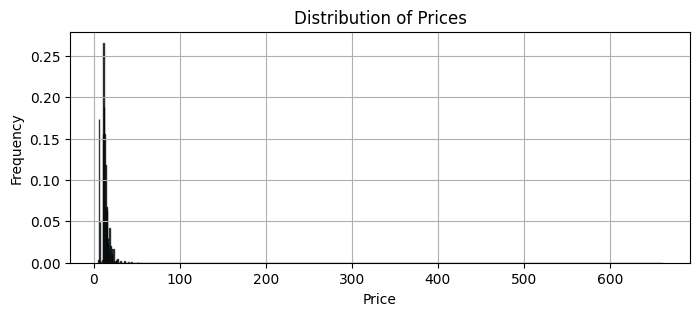

In [17]:
data_price = df_cleaned["price"]
plt.figure(figsize=(8,3))
plt.hist(data_price, bins=1000, color="skyblue", edgecolor="black", alpha=0.80, density=True)
plt.title("Distribution of Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [18]:
df.describe()

,date,price,quantity,customer_num,abs_quantity
count,531150,531150.000000,531150.000000,531095.0,531150.000000
mean,2019-07-04 00:23:47.393391616,12.669787,9.988540,15222.612241,11.003082
min,2018-12-01 00:00:00,5.130000,-80995.000000,12004.0,1.000000
25%,2019-03-28 00:00:00,10.990000,1.000000,13798.0,1.000000
50%,2019-07-20 00:00:00,11.940000,3.000000,15146.0,3.000000
75%,2019-10-19 00:00:00,14.090000,10.000000,16727.0,11.000000
max,2019-12-09 00:00:00,660.620000,80995.000000,18287.0,80995.000000
std,NaN,8.525988,217.700768,1716.633588,217.651849


5.2 Boxplot of Price

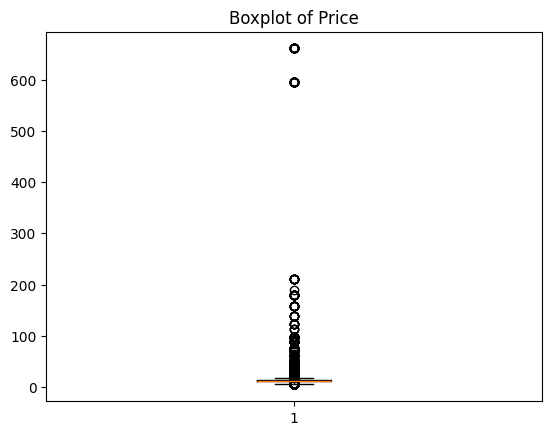

In [19]:
plt.boxplot(data_price)
plt.title("Boxplot of Price")
plt.show()

5.3 Distribution of Quantity

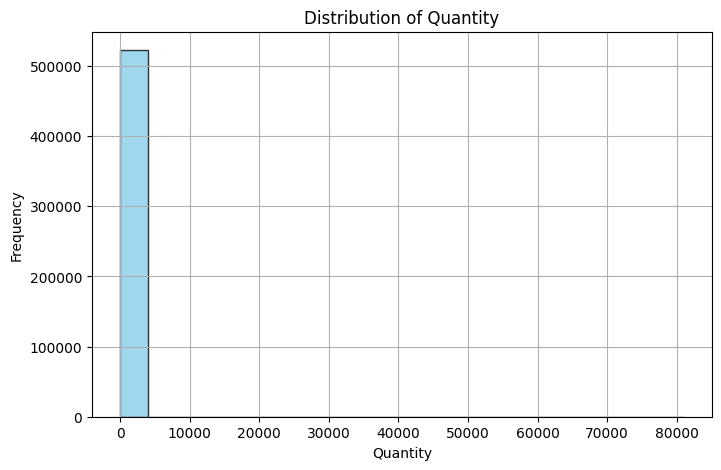

In [20]:
data_quantity = df_cleaned["quantity"]
plt.figure(figsize=(8, 5))
plt.hist(data_quantity, bins=20, color="skyblue", edgecolor="black", alpha=0.8)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.grid("True")
plt.show()

5.4 Boxplot of Quantity

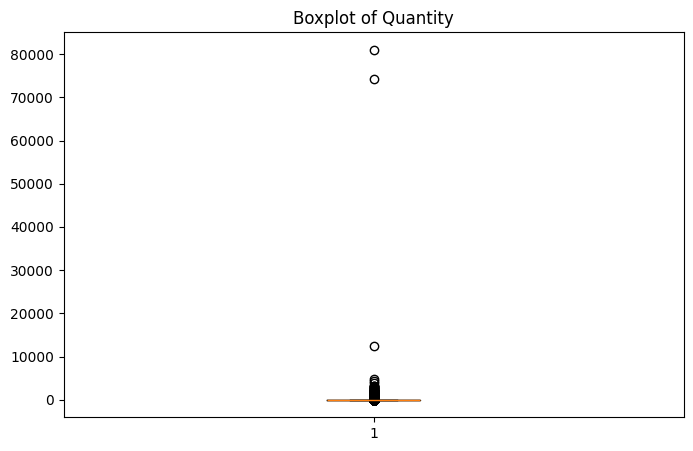

In [21]:
plt.figure(figsize=(8, 5))
plt.boxplot(data_quantity)
plt.title("Boxplot of Quantity")
plt.show()

5.5 Number of unique values per categorical variables

In [22]:
print(f"Number of unique 'product_num': {df_cleaned["product_num"].nunique()}")
print(f"Number of unique 'product_name': {df_cleaned["product_name"].nunique()}")
print(f"Number of unique 'customer_num': {df_cleaned["customer_num"].nunique()}")
print(f"Number of unique 'country': {df_cleaned["country"].nunique()}")


Number of unique 'product_num': 3753
Number of unique 'product_name': 3753
Number of unique 'customer_num': 4718
Number of unique 'country': 38


5.6 Top 10 Country by Frequency

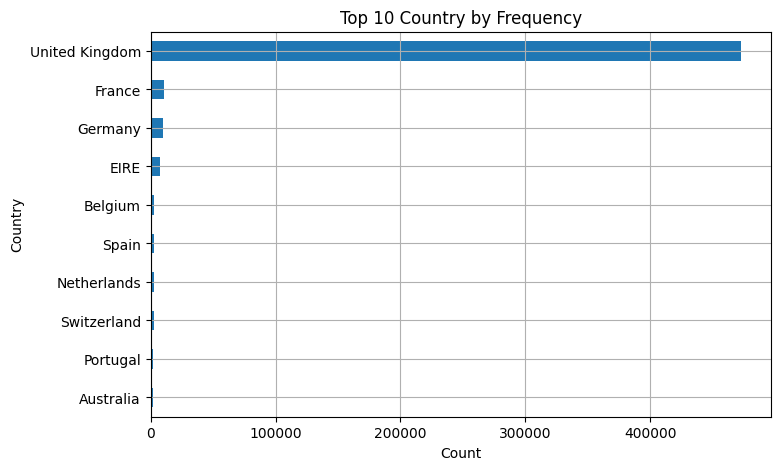

Top 10 Country by Frequency in Percentage
country
Australia          0.31
Portugal           0.35
Switzerland        0.44
Netherlands        0.45
Spain              0.46
Belgium            0.48
EIRE               1.49
Germany            1.96
France             1.99
United Kingdom    90.45
Name: proportion, dtype: float64


In [49]:
data_country = df_cleaned["country"].value_counts().sort_values(ascending=True).tail(10)
plt.figure(figsize=(8, 5))
data_country.plot(kind="barh")
plt.title("Top 10 Country by Frequency")
plt.xlabel('Count')
plt.ylabel('Country')
plt.grid(True)
plt.show()

# Top 10 Country by Frequency in Percentage
data_country_percentage = df_cleaned["country"].value_counts(normalize=True).sort_values(ascending=True).tail(10)
print("Top 10 Country by Frequency in Percentage")
print(round((data_country_percentage * 100), 2))


#### Insight:
*United Kingdom has the most number of transactions.*

5.7 Top 10 Products by Frequency

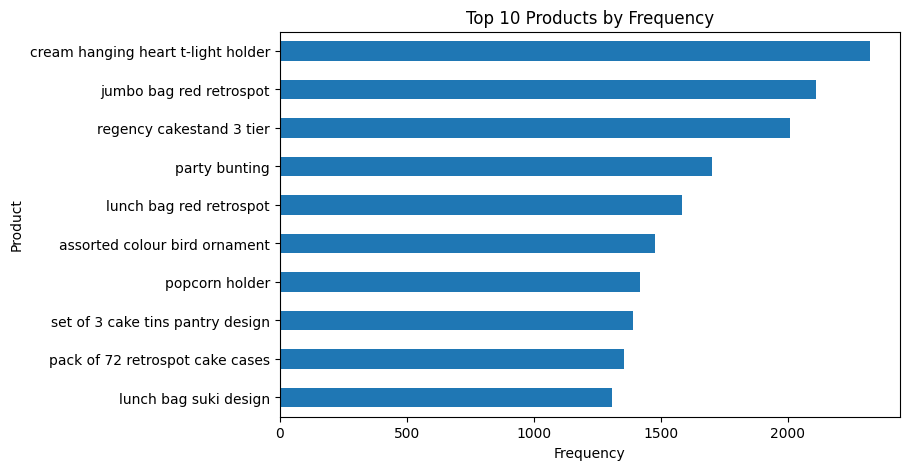

In [24]:
data_product_by_frequency = df_cleaned["product_name"].value_counts().sort_values(ascending=True).tail(10)
plt.figure(figsize=(8, 5))
data_product_by_frequency.plot(kind="barh")
plt.title("Top 10 Products by Frequency")
plt.ylabel("Product")
plt.xlabel("Frequency")
plt.show()

### Insight
*Cream Hanging Heart T-light Holder is the most purchased or popular product.*

5.8 Top 10 Frequent Customer

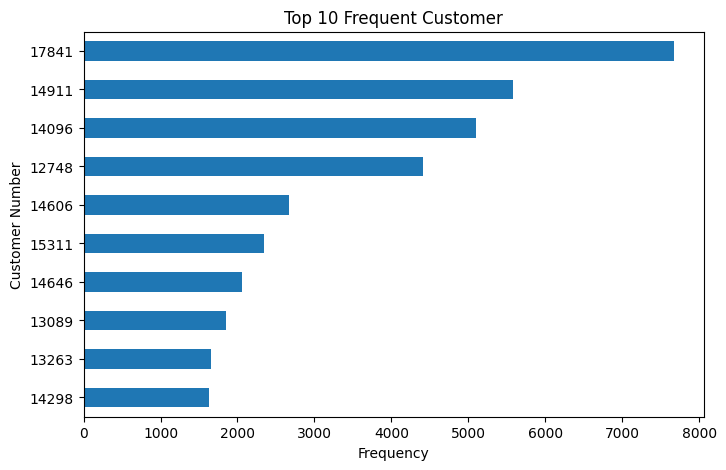

In [25]:
data_frequent_customer = df_cleaned["customer_num"].value_counts().sort_values().tail(10)
plt.figure(figsize=(8, 5))
data_frequent_customer.plot(kind="barh")
plt.title("Top 10 Frequent Customer")
plt.ylabel("Customer Number")
plt.xlabel("Frequency")
plt.show()


### Insight

*Customer 17841 is the most frequent customer.*

## Step 6: Bivariate Analysis

6.1 Top 10 Product by Average Quantity Per Order

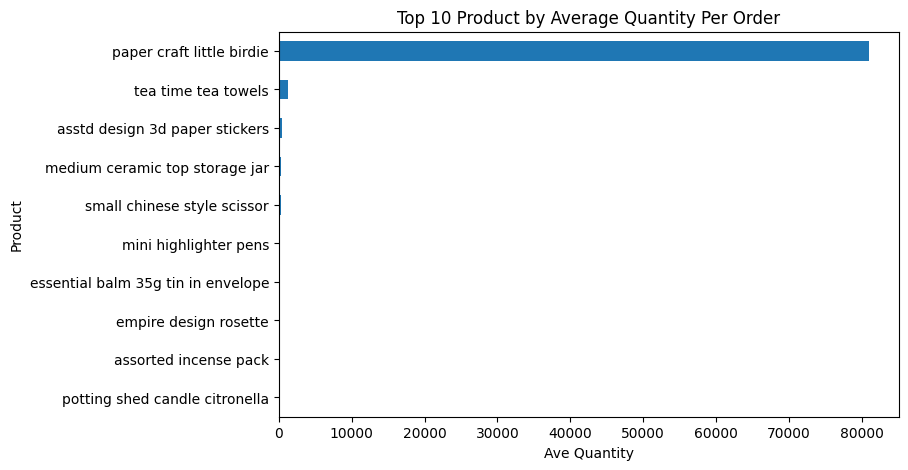

product_name
potting shed candle citronella          135.000000
assorted incense pack                   149.333333
empire design rosette                   151.571429
essential balm 35g tin in envelope      189.806452
mini highlighter pens                   210.000000
small chinese style scissor             246.814815
medium ceramic top storage jar          312.132000
asstd design 3d paper stickers          403.000000
tea time tea towels                    1300.000000
paper craft little birdie             80995.000000
Name: quantity, dtype: float64


In [26]:
data_product_by_ave_quantity = df_cleaned.groupby("product_name")["quantity"].mean().sort_values(ascending=True).tail(10)
plt.figure(figsize=(8, 5))
data_product_by_ave_quantity.plot(kind="barh")
plt.title("Top 10 Product by Average Quantity Per Order")
plt.ylabel("Product")
plt.xlabel("Ave Quantity")
plt.show()

print(data_product_by_ave_quantity)

### Insight

*Paper Craft Little Birdie is the most purchased in bulk.*

6.2 Top 10 Product with most sold items

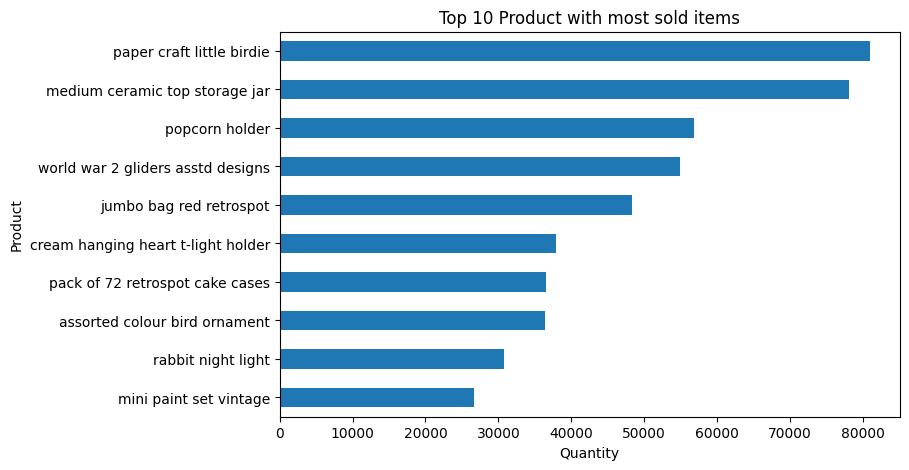

In [27]:
data_product_most_item_sold = df_cleaned.groupby("product_name")["quantity"].sum().sort_values().tail(10)
plt.figure(figsize=(8,5))
data_product_most_item_sold.plot(kind="barh")
plt.title("Top 10 Product with most sold items")
plt.ylabel("Product")
plt.xlabel("Quantity")
plt.show()

### Insight

*Paper Craft Little Birdie has the highest number of quantity sold.*

6.3 Top 10 Least expensive Products

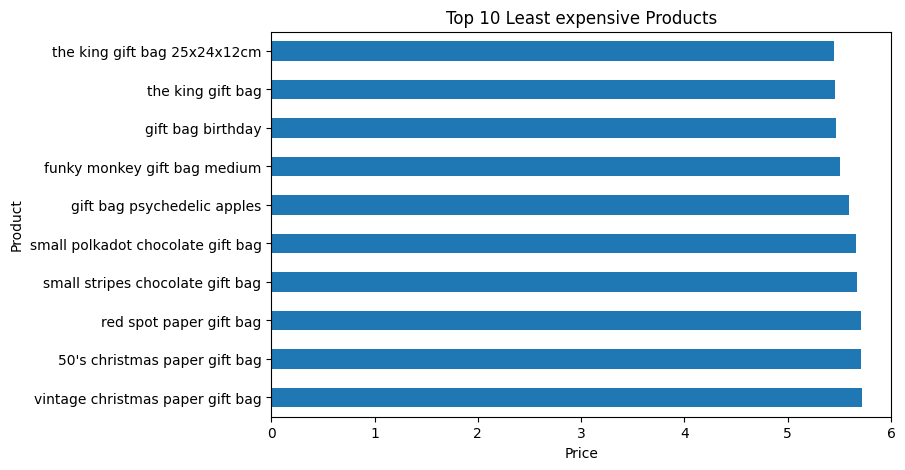

In [28]:
data_product_by_price = df.groupby("product_name")["price"].mean().sort_values(ascending=False).tail(10)
plt.figure(figsize=(8,5))
data_product_by_price.plot(kind="barh")
plt.title("Top 10 Least expensive Products")
plt.xlabel("Price")
plt.ylabel("Product")
plt.show()

### Insight

*The King gift bag 25x24x12cm, The king gift bag, and Gift bag birthday are the least expensive products.*

6.4 Top 10 Most expensive Products

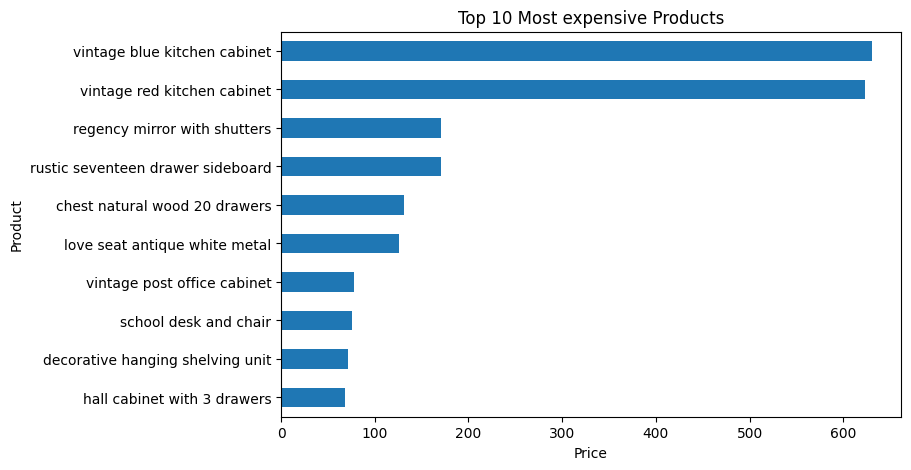

In [29]:
data_product_by_price = df.groupby("product_name")["price"].mean().sort_values().tail(10)
plt.figure(figsize=(8,5))
data_product_by_price.plot(kind="barh")
plt.title("Top 10 Most expensive Products")
plt.xlabel("Price")
plt.ylabel("Product")
plt.show()

6.5 Percentage of Location of Top 10 Frequent Customer

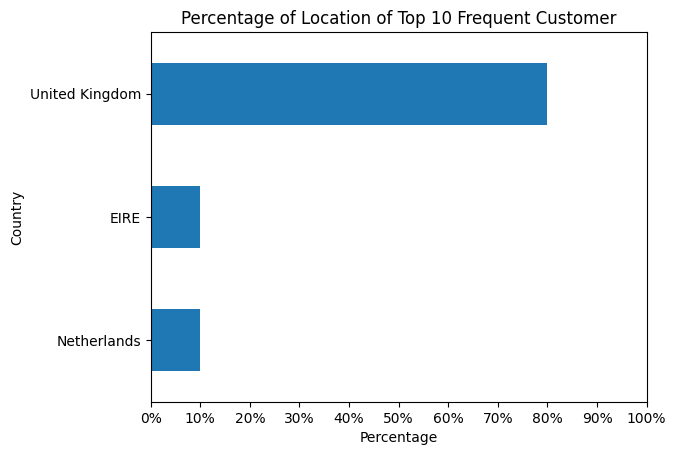

In [30]:
top_10_customer = df_cleaned["customer_num"].value_counts().nlargest(10).index
top_10_data = df_cleaned[df_cleaned["customer_num"].isin(top_10_customer)]
top_customer_loc = top_10_data.groupby("customer_num")["country"].agg(lambda x: x.mode().loc[0])
top_customer_loc.value_counts(normalize=True).sort_values().plot(kind="barh")
plt.title("Percentage of Location of Top 10 Frequent Customer")
plt.xlabel("Percentage")
plt.ylabel("Country")
plt.xticks(
    [i/10 for i in range(0, 11)],
    [f"{i*10}%" for i in range (0, 11)]
    )
plt.show()



### Insight

*8 out of 10 Top Frequent Customers are from the United Kingdom*

### Insight

*Vintage blue kitchen cabinet is the most expensive product.*

## Step 7: Detecting Outliers

7.1 Boxplot of Price

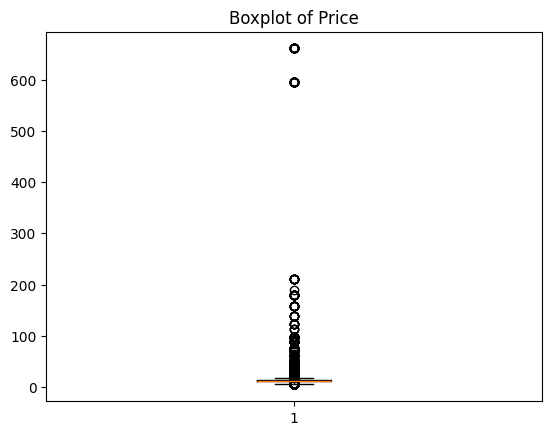

In [31]:
plt.boxplot(df_cleaned["price"])
plt.title("Boxplot of Price")
plt.show()

7.2 Boxplot of Quantity

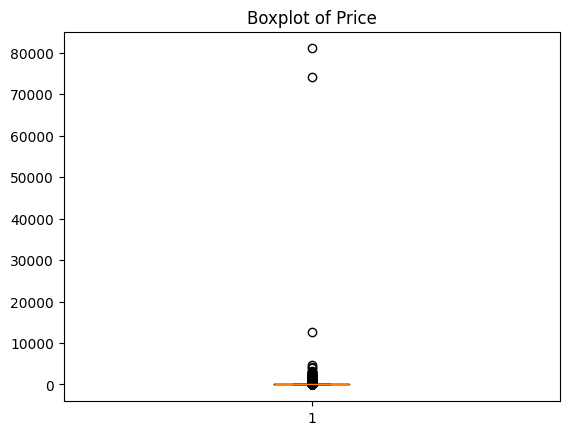

In [32]:
plt.boxplot(df_cleaned["quantity"])
plt.title("Boxplot of Price")
plt.show()

7.3 Percent Outliers of Price and Quantity

In [33]:
def iqr(column):
    return column.quantile(0.75) - column.quantile(0.25)

def percent_outlier (column_name, dataframe):
    column = dataframe[column_name]

    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    interquantile = column.agg(iqr)

    lower_bound =  q1 - 1.5 * interquantile
    higher_bound = q3 + 1.5 * interquantile

    outliers = dataframe[(column < lower_bound) | (column > higher_bound)]
    return (len(outliers) / len(dataframe)) * 100

price_outlier = percent_outlier("price", df_cleaned)
quantity_outlier = percent_outlier("quantity", df_cleaned)

print(f"Percentage of Price Outlier: {price_outlier:.2f}%")
print(f"Percentage of Quantity Outlier: {quantity_outlier:.2f}%")


Percentage of Price Outlier: 18.43%
Percentage of Quantity Outlier: 5.13%


## Step 8: Initial Findings Summary

In [34]:
product_per_transaction = df.groupby("transaction_num")["product_num"].nunique()
print(f"Average Products purchased per transaction: {product_per_transaction.mean():.2f}")

Average Products purchased per transaction: 22.64


### Key Findings

- Customers in the **United Kingdom** account for the majority of transactions (see bar chart 5.6).  
- **8 out of the Top 10 most frequent customers** are based in the United Kingdom (see bar chart 6.5), reinforcing the strength of the local customer base.  
- The most transacted product, *Cream Hanging Heart T-light Holder*, does **not** appear among the **top 10 most expensive** or **least expensive products** (see bar chart 5.7), indicating that popularity is not solely driven by price.  
- *Paper Craft Little Birdie* ranks highest in both **total quantity sold** and **average quantity per transaction** (see bar charts 6.1–6.2).  
- *King Gift Bag 25x24x12cm* is identified as the **least expensive product** (see bar chart 6.3).  
- *Vintage Blue Kitchen Cabinet* is the **most expensive product** in the dataset (see bar chart 6.4).  
- On average, **23 products are purchased per transaction**, suggesting strong **bulk-purchasing behavior**.  
- Outlier detection shows that **18.43% of price values** and **5.13% of quantity values** fall outside the interquartile range, highlighting **skewed distribution** and **exceptional product behaviors**.  


## Step 9: Cleaning Outliers

**Price Outliers (18.43%)**

- The high proportion of outliers in price is expected due to the wide range of product types — from low-cost gift bags to high-value items like vintage cabinets. This diversity in pricing structure is inherent to the business and does not indicate data issues.

- Action: Outliers retained for accurate representation of product value range.



**Quantity Outliers (5.13%)**

- Outliers in quantity likely reflect bulk or wholesale purchases, which may offer insight into customer segmentation or purchase patterns. These will be analyzed separately in later steps to better understand buyer behavior.

- Action: Outliers kept and flagged for further analysis.

## Step 10: Feature Engineering

In [35]:
def create_segment(df, group_col, target_col, agg_func, new_column_name, q=4, label=None, reverse_label=False):
    grouped = df.groupby(group_col)[target_col].agg(agg_func)

    if pd.api.types.is_datetime64_any_dtype(grouped):
        max_date = df[target_col].max()
        grouped = (max_date - grouped).dt.days

    if reverse_label and label:
        label = label[::-1]
    
    bucket = pd.qcut(grouped, q=q, labels=label)
    df[new_column_name] = df[group_col].map(bucket)


# Revenue
df_cleaned["revenue"] = df_cleaned["price"] * df_cleaned["quantity"]

# Day Name
df_cleaned["day_name"] = df_cleaned["date"].dt.day_name()

# Month 
df_cleaned["month"] = df_cleaned["date"].dt.month

# Year
df_cleaned["year"] = df_cleaned["date"].dt.year

# Year_month
df_cleaned["year_month_dt"] = pd.to_datetime(df_cleaned["year"].astype(str) + "-" + df_cleaned["month"].astype(str).str.zfill(2))
df_cleaned["year_month_str"] = df_cleaned["year_month_dt"].dt.strftime("%Y-%B")

# customer recency
create_segment(
    df_cleaned,
    group_col = "customer_num",
    target_col = "date", 
    agg_func = "max", 
    new_column_name = "customer_recency",
    label = ["least_active", "less_active", "more_active", "most_active"], 
    reverse_label = True
)

# Customer's frequency category
create_segment(
    df_cleaned,
    group_col = "customer_num",
    target_col = "customer_num", 
    agg_func = "count", 
    new_column_name = "customer_frequency",
    label = ["least_frequent", "less_frequent", "more_frequent", "most_frequent"]
)

# Customer's contribution
create_segment(
    df_cleaned,
    group_col = "customer_num",
    target_col = "revenue", 
    agg_func = "sum", 
    new_column_name = "customer_contribution",
    label = ["least_contributor", "less_contributor", "more_contributor", "most_contributor"]
)

# Price category
create_segment(
    df_cleaned,
    group_col = "product_num",
    target_col = "price", 
    agg_func = "mean", 
    new_column_name = "price_category",
    label = ["least_expensive", "less_expensive", "more_expensive", "most_expensive"]
)


# Quantity Category
create_segment(
    df_cleaned,
    group_col = "product_num",
    target_col = "quantity", 
    agg_func = "sum", 
    new_column_name = "product_vol_category",
    label = ["least_volume", "less_volume", "more_volume", "most_volume"]
)

df_cleaned


,transaction_num,date,product_num,product_name,price,quantity,customer_num,country,no_C_transaction_num,abs_quantity,...,day_name,month,year,year_month_dt,year_month_str,customer_recency,customer_frequency,customer_contribution,price_category,product_vol_category
0,581482,2019-12-09,22485,set of 2 wooden market crates,21.47,12,17490,United Kingdom,581482,12,...,Monday,12,2019,2019-12-01,2019-December,most_active,more_frequent,most_contributor,most_expensive,more_volume
1,581475,2019-12-09,22596,christmas star wish list chalkboard,10.65,36,13069,United Kingdom,581475,36,...,Monday,12,2019,2019-12-01,2019-December,most_active,most_frequent,most_contributor,least_expensive,most_volume
2,581475,2019-12-09,23235,storage tin vintage leaf,11.53,12,13069,United Kingdom,581475,12,...,Monday,12,2019,2019-12-01,2019-December,most_active,most_frequent,most_contributor,more_expensive,more_volume
3,581475,2019-12-09,23272,tree t-light holder willie winkie,10.65,12,13069,United Kingdom,581475,12,...,Monday,12,2019,2019-12-01,2019-December,most_active,most_frequent,most_contributor,least_expensive,less_volume
4,581475,2019-12-09,23239,set of 4 knick knack tins poppies,11.94,6,13069,United Kingdom,581475,6,...,Monday,12,2019,2019-12-01,2019-December,most_active,most_frequent,most_contributor,more_expensive,more_volume
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522597,536585,2018-12-01,37449,ceramic cake stand + hanging cakes,20.45,2,17460,United Kingdom,536585,2,...,Saturday,12,2018,2018-12-01,2018-December,less_active,less_frequent,less_contributor,most_expensive,more_volume
522598,536590,2018-12-01,22776,sweetheart 3 tier cake stand,20.45,1,13065,United Kingdom,536590,1,...,Saturday,12,2018,2018-12-01,2018-December,least_active,least_frequent,least_contributor,most_expensive,more_volume
522599,536590,2018-12-01,22622,box of vintage alphabet blocks,20.45,2,13065,United Kingdom,536590,2,...,Saturday,12,2018,2018-12-01,2018-December,least_active,least_frequent,least_contributor,most_expensive,more_volume
522600,536591,2018-12-01,37449,ceramic cake stand + hanging cakes,20.45,1,14606,United Kingdom,536591,1,...,Saturday,12,2018,2018-12-01,2018-December,most_active,most_frequent,most_contributor,most_expensive,more_volume


## Step 11: Exploring and Visualizing New Features

**Stakeholders questions**

1. How was the sales trend over the months?

2. What are the most frequently purchased products?

3. How many products does the customer purchase in each transaction?

4. What are the most profitable segment customers?

5. Based on your findings, what strategy could you recommend to the business to gain more profit?

11.1 Monthly Revenue

Sum of all the revenue in a month.

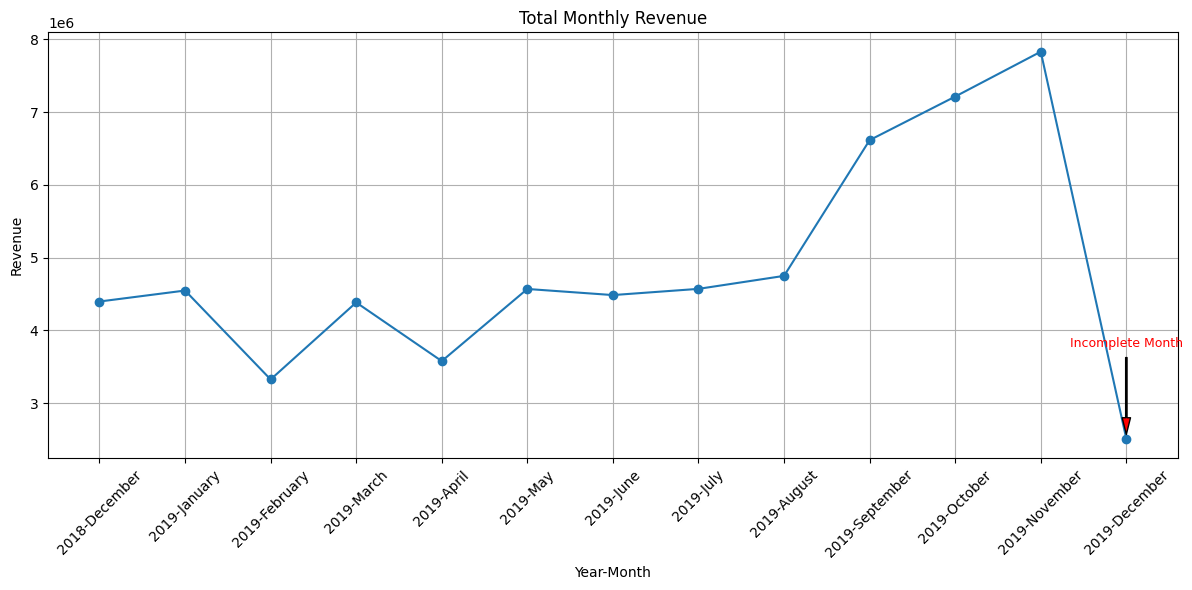

Month-over-Month Growth (Aug 2019 to Sept 2019)
39.24


In [60]:
# Monthly Revenue Trend
monthly_revenue = df_cleaned.groupby(
    ["year_month_dt", "year_month_str"])["revenue"].sum().reset_index().sort_values("year_month_dt")

plt.figure(figsize=(12,6))
plt.plot(monthly_revenue["year_month_str"], monthly_revenue["revenue"], marker="o")
plt.title("Total Monthly Revenue")
plt.xlabel("Year-Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Identify December (last month in the dataset)
last_idx = monthly_revenue.index[-1]
last_month_x =  monthly_revenue["year_month_str"].iloc[-1]
last_month_y =  monthly_revenue["revenue"].iloc[-1]

# Add annotation for incomplete month
plt.annotate(
    "Incomplete Month",
    xy=(last_idx, last_month_y),
    xytext=(last_idx, last_month_y + (last_month_y * 0.5)),  # shift note upward
    arrowprops=dict(facecolor="red", shrink=0.05, width=1, headwidth=6),
    ha="center",
    fontsize=9,
    color="red"
)

plt.show()


# Month-over-Month Growth (Aug 2019 to Sept 2019)
aug_2019_revenue = monthly_revenue.iloc[8, 2]
sept__2019_revenue = monthly_revenue.iloc[9, 2]

print("Month-over-Month Growth (Aug 2019 to Sept 2019)")
print(round(((sept__2019_revenue - aug_2019_revenue) / aug_2019_revenue) * 100,2))



11.2 Average Daily Revenue per Month

Sum of all daily revenue in a month divided by the total number of days (with revenue) within a month.

Using daily averages to normalize incomplete months.

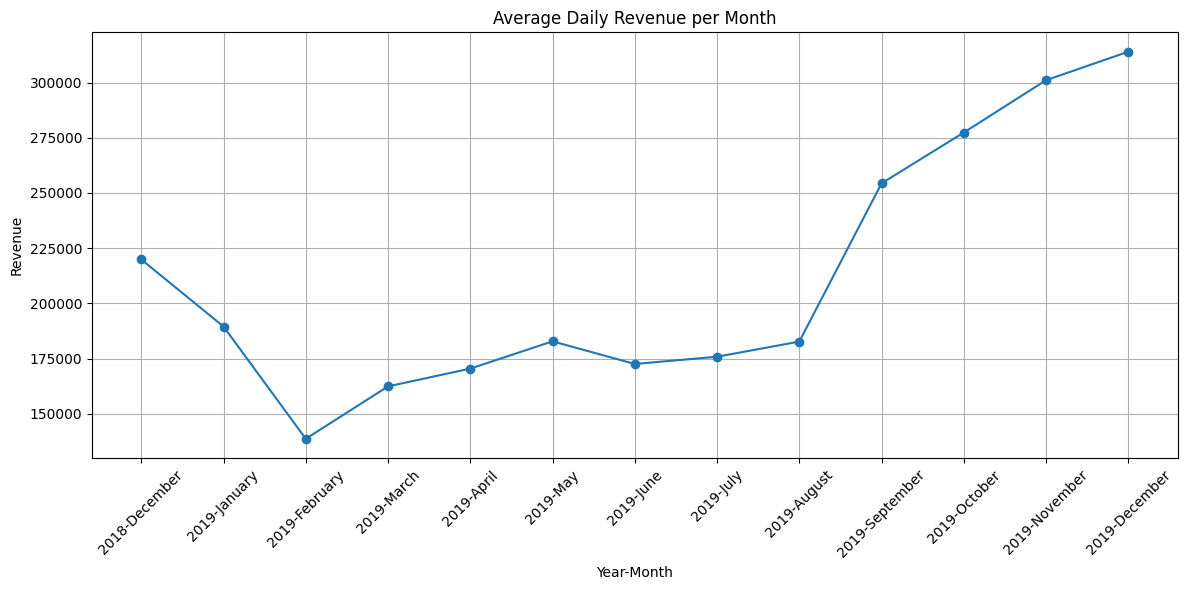

In [37]:
# Average Daily Revenue per Month
daily_revenue = df_cleaned.groupby(["date", "year_month_dt", "year_month_str"])["revenue"].sum().reset_index()
daily_ave_per_month = daily_revenue.groupby(["year_month_dt", "year_month_str"])["revenue"].mean().reset_index().sort_values("year_month_dt")
plt.figure(figsize=(12,6))
plt.plot(daily_ave_per_month["year_month_str"], daily_ave_per_month["revenue"], marker="o")
plt.title("Average Daily Revenue per Month")
plt.xlabel("Year-Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


11.3 Average Revenue per Weekday

Average revenue per weekday

<Figure size 800x600 with 0 Axes>

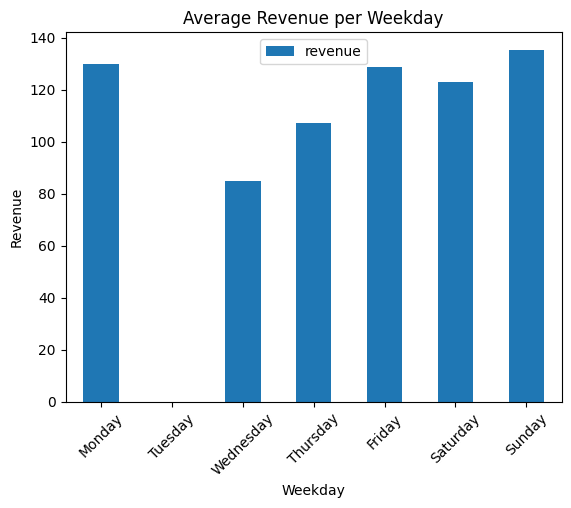

Percent Difference: Wednesday(lowest revenue) vs Sunday(highest revenue)
59.32


In [67]:
weekday_sorting = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_cleaned["day_name"] = df_cleaned["day_name"].astype(pd.CategoricalDtype(categories=weekday_sorting, ordered=True))
weekday_ave_revenue = df_cleaned.groupby("day_name", observed=False)["revenue"].mean().reset_index()
weekday_ave_revenue["revenue"]= weekday_ave_revenue["revenue"].fillna(0) #To avoid warning since weekday_ave_revenue is a view dataframe
plt.figure(figsize=(8,6))
weekday_ave_revenue.set_index("day_name").plot(kind="bar")
plt.title("Average Revenue per Weekday")
plt.xlabel("Weekday")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()



# Wednesday(lowest revenue) vs Sunday(highest revenue)
wed_revenue = weekday_ave_revenue.set_index("day_name").loc["Wednesday", "revenue"]
sun_revenue = weekday_ave_revenue.set_index("day_name").loc["Sunday", "revenue"]

wed_vs_sun = ((sun_revenue - wed_revenue) / wed_revenue) * 100

print("Percent Difference: Wednesday(lowest revenue) vs Sunday(highest revenue)")
print(round(wed_vs_sun, 2))



11.4 Percentage of Customer Recency in Total Revenue

customer_recency


<Figure size 800x600 with 0 Axes>

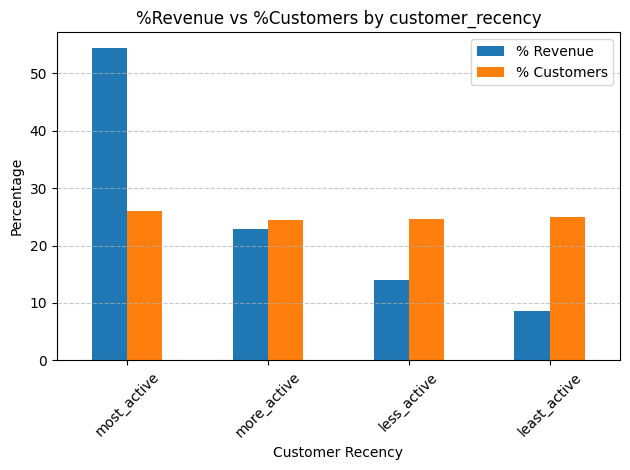

  customer_recency  percentage_revenue  percentage_customer
0      most_active           54.444643            25.943196
1      more_active           22.924934            24.459517
2      less_active           14.074539            24.586689
3     least_active            8.555884            25.010598

customer_frequency


<Figure size 800x600 with 0 Axes>

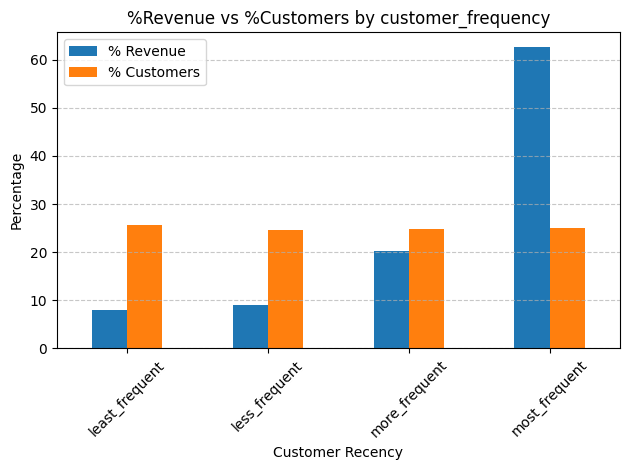

  customer_frequency  percentage_revenue  percentage_customer
0     least_frequent            8.058489            25.604070
1      less_frequent            9.083429            24.629080
2      more_frequent           20.284711            24.798643
3      most_frequent           62.573370            24.968207

customer_contribution


<Figure size 800x600 with 0 Axes>

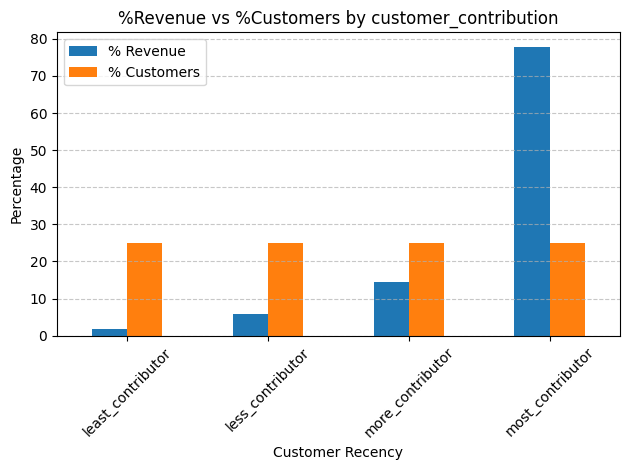

  customer_contribution  percentage_revenue  percentage_customer
0     least_contributor            1.780703            25.010598
1      less_contributor            5.851840            24.989402
2      more_contributor           14.502953            24.989402
3      most_contributor           77.864504            25.010598

price_category


<Figure size 800x600 with 0 Axes>

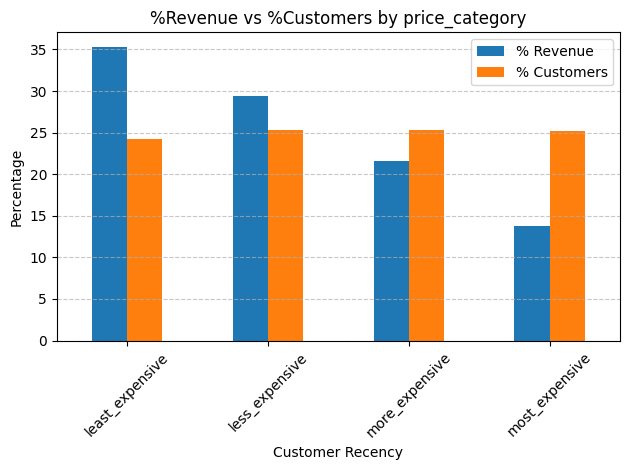

    price_category  percentage_revenue  percentage_customer
0  least_expensive           35.291892            24.220236
1   less_expensive           29.365087            25.344480
2   more_expensive           21.563965            25.298357
3   most_expensive           13.779056            25.136927

product_vol_category


<Figure size 800x600 with 0 Axes>

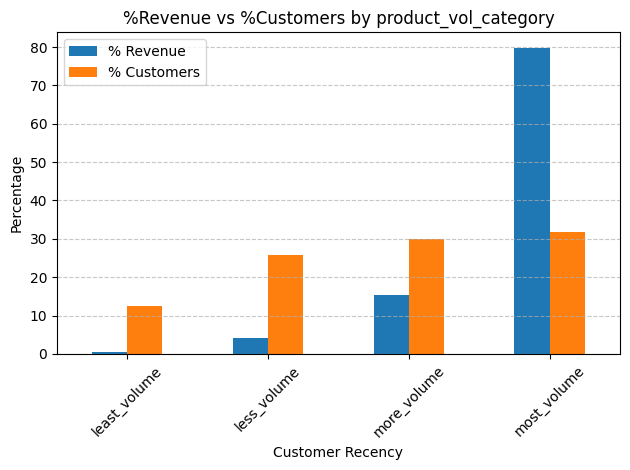

  product_vol_category  percentage_revenue  percentage_customer
0         least_volume            0.581977            12.524769
1          less_volume            4.130488            25.842159
2          more_volume           15.454617            29.880424
3          most_volume           79.832918            31.752648



In [39]:
def compare_revenue_vs_customers(df, col_segment):

    revenue_per_segment  = df.groupby(col_segment, observed=False)["revenue"].sum().reset_index()
    total_revenue = revenue_per_segment["revenue"].sum()
    revenue_per_segment["percentage_revenue"] = (revenue_per_segment["revenue"] / total_revenue) * 100

    customer_per_segment = df.groupby(col_segment, observed=False)["customer_num"].nunique().reset_index()
    total_customer = customer_per_segment["customer_num"].sum()
    customer_per_segment["percentage_customer"] = (customer_per_segment["customer_num"] / total_customer) * 100

    merge_revenue_customer = pd.merge(
    revenue_per_segment[[col_segment, "percentage_revenue"]],
    customer_per_segment[[col_segment, "percentage_customer"]],
    on=col_segment
    )

    plt.figure(figsize=(8,6))
    merge_revenue_customer.plot(x=col_segment, kind="bar")
    plt.title(f"%Revenue vs %Customers by {col_segment}")
    plt.ylabel("Percentage")
    plt.xlabel("Customer Recency")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(["% Revenue", "% Customers"])
    plt.tight_layout()
    plt.show()
    

    return merge_revenue_customer

for col in ["customer_recency", "customer_frequency", "customer_contribution", "price_category", "product_vol_category"]:
    print(f"{col}")
    print(compare_revenue_vs_customers(df_cleaned, col))
    print()



<Figure size 800x600 with 0 Axes>

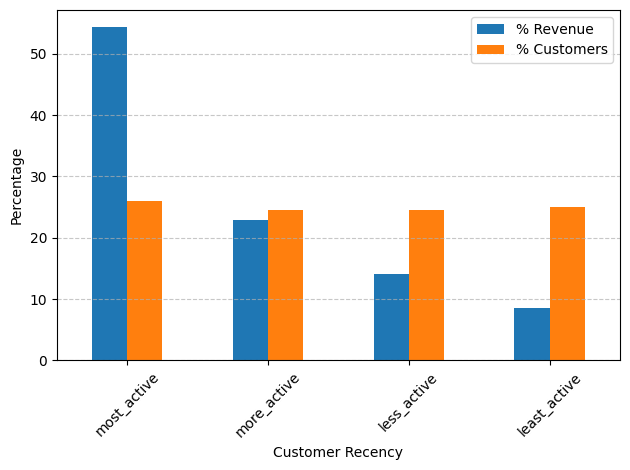

,customer_recency,percentage_revenue,percentage_customer
0,most_active,54.444643,25.943196
1,more_active,22.924934,24.459517
2,less_active,14.074539,24.586689
3,least_active,8.555884,25.010598


In [41]:
revenue_per_segment  = df_cleaned.groupby("customer_recency", observed=False)["revenue"].sum().reset_index()
total_revenue = revenue_per_segment["revenue"].sum()
revenue_per_segment["percentage_revenue"] = (revenue_per_segment["revenue"] / total_revenue) * 100


customer_per_segment = df_cleaned.groupby("customer_recency", observed=False)["customer_num"].nunique().reset_index()
total_customer = customer_per_segment["customer_num"].sum()
customer_per_segment["percentage_customer"] = (customer_per_segment["customer_num"] / total_customer) * 100


merge_revenue_customer = pd.merge(
    revenue_per_segment[["customer_recency", "percentage_revenue"]],
    customer_per_segment[["customer_recency", "percentage_customer"]],
    on="customer_recency"
)


plt.figure(figsize=(8,6))
merge_revenue_customer.plot(x="customer_recency", kind="bar")
plt.ylabel("Percentage")
plt.xlabel("Customer Recency")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(["% Revenue", "% Customers"])
plt.tight_layout()
plt.show()

merge_revenue_customer


## Step 12: Final Recommendations

### Summary

Analysis shows that transactions are highly concentrated in the **United Kingdom (92.45%)**, driven by bulk-purchasing behavior and seasonal peaks beginning in **September (+39.24% MoM revenue growth)**. Customer segmentation indicates that the **top 25% of frequent customers** generate **~63% of revenue**, while the **top 25% of high-contribution customers** account for **~78%**, underscoring the importance of **loyalty and retention**. 

Average daily revenue patterns reveal **Sunday as the strongest day** (**+53.32% vs Wednesday**), while **Wednesdays consistently underperform**. Popular products such as the *Cream Hanging Heart T-light Holder* and *Paper Craft Little Birdie* drive transaction volume but not necessarily profitability, highlighting opportunities to better balance **volume vs margin**.


### Detailed Recommendations

---

### 1. Strengthen the **UK Customer Base**
- **Finding:** **92.45%** of transactions and **8/10** frequent customers are from the **UK**.  
- **Action:** Launch targeted **loyalty campaigns** (points, tiered rewards, seasonal bundles).  
- **Metric:** Increase **repeat purchase rate** and **UK average transaction value** by **10–15%** in 6 months.  

---

### 2. Optimize **Product Mix**: Balance Popularity vs Profitability
- **Finding:** Top sellers (**Cream Hanging Heart T-light Holder**, **Paper Craft Little Birdie**) are **not** among the most expensive.  
- **Action:** **Bundle** popular items with **higher-margin products** to lift profitability.  
- **Metric:** Track **margin uplift %** from bundled sales.  

---

### 3. Capitalize on **Seasonal Demand Peaks**
- **Finding:** **September revenue grew +39.24% vs August**, signaling **Q4 holiday demand**.  
- **Action:** Increase **stock, marketing, and promotions** 1–2 months before seasonal peaks.  
- **Metric:** Target **20% YoY increase** in **Q4 revenue**.  

---

### 4. Address **Midweek Sales Slump**
- **Finding:** **Wednesday revenue** is **53.32% lower** than **Sunday**.  
- **Action:** Run **midweek-exclusive promotions** (discount codes, “Wednesday Flash Sale”).  
- **Metric:** Raise **Wednesday sales** to within **20% of Monday levels** in 3 months.  

---

### 5. Leverage **High-Contribution Customers**
- **Finding:** Top 25% **most frequent** customers generate **~63%** of revenue, while top 25% **most contributing** customers generate **~78%**.  
- **Action:** Offer **personalized deals** and **early access sales** to this group.  
- **Metric:** Increase **retention rate** of top customers by **15%**.  

---

### 6. Explore **International Growth Opportunities**
- **Finding:** The **UK dominates**, but over-reliance on one region is risky.  
- **Action:** Pilot **localized campaigns** in **1–2 underrepresented regions**.  
- **Metric:** Achieve **5–10% revenue share outside the UK** in 12 months.  
